In [1]:
# flake8: noqa
# ---
# jupyter:
#   jupytext:
#     formats: ipynb,py:percent
#     text_representation:
#       extension: .py
#       format_name: percent
#       format_version: '1.3'
#       jupytext_version: 1.13.8
#   kernelspec:
#     display_name: Python 3 (ipykernel)
#     language: python
#     name: python3
# ---

# Example: Polynomial function

In [2]:
# Simple plotting of forward-model with a single response and parameters
from matplotlib import pyplot as plt


def plot_result(
    A, response_x_axis, trans_func=lambda x: x, priors=[], show_params=False
):
    responses = forward_model(A, priors, response_x_axis)
    plt.rcParams["figure.figsize"] = [15, 4]
    figures = 1 + len(A) if show_params else 1
    fig, axs = plt.subplots(1, figures)

    if show_params:
        axs[0].plot(response_x_axis, responses)
        for i, param in enumerate(A):
            A_trans = np.array([trans_func(v, *priors[i]) for v in param])
            axs[i + 1].hist(A_trans, bins=10)
    else:
        axs.plot(response_x_axis, responses)
    plt.show()

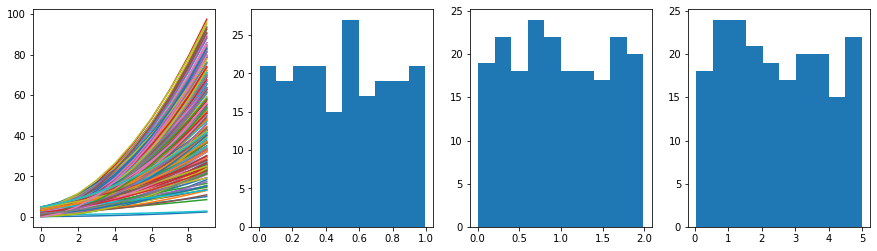

In [3]:
# Polynomial forward model with observations
import numpy as np
from scipy.special import erf
from math import sqrt


def uniform(x, min_x, max_x):
    y = 0.5 * (1 + erf(x / sqrt(2.0)))
    return y * (max_x - min_x) + min_x


def forward_model(A, priors, response_x_axis):
    responses = []
    for params in A.T:
        l = [uniform(x, *priors[i]) for i, x in enumerate(params)]
        response = [l[0] * x**2 + l[1] * x + l[2] for x in response_x_axis]
        responses.append(response)
    return np.array(responses).T


observation_values = np.array(
    [2.8532509308, 7.20311703432, 21.3864899107, 31.5145559347, 53.5676660405]
)

observation_errors = np.array([0.5 * (x + 1) for x, _ in enumerate(observation_values)])
observation_x_axis = [0, 2, 4, 6, 8]
response_x_axis = range(10)
realizations = 200
priors = [(0, 1), (0, 2), (0, 5)]
A = np.asfortranarray(np.random.normal(0, 1, size=(3, realizations)))
plot_result(A, response_x_axis, uniform, priors, True)

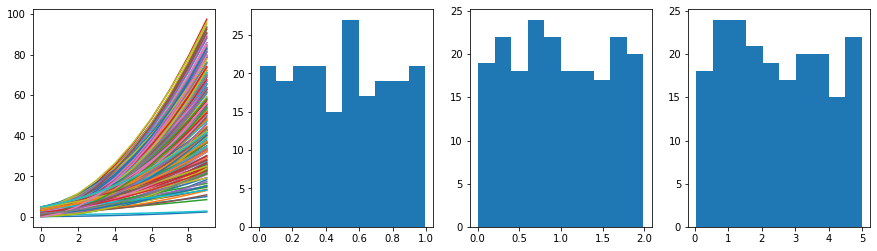

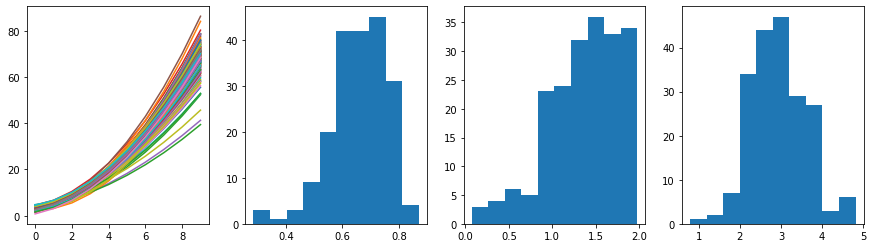

In [4]:
import numpy as np
from ert.analysis import ies


def ensemble_smoother():
    plot_result(A, response_x_axis, uniform, priors, True)
    responses_before = forward_model(A, priors, response_x_axis)
    S = responses_before[observation_x_axis]
    noise = np.random.rand(*S.shape)
    E = ies.make_E(observation_errors, noise)
    R = np.identity(len(observation_errors))
    D = ies.make_D(observation_values, E, S)
    D = (D.T / observation_errors).T
    E = (E.T / observation_errors).T
    S = (S.T / observation_errors).T

    X = ies.make_X(S, R, E, D)
    new_A = A @ X

    plot_result(new_A, response_x_axis, uniform, priors, True)


ensemble_smoother()

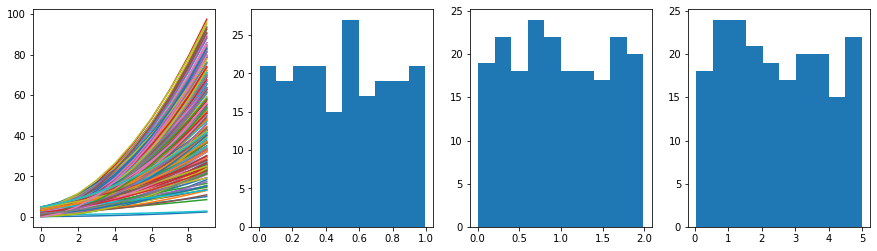

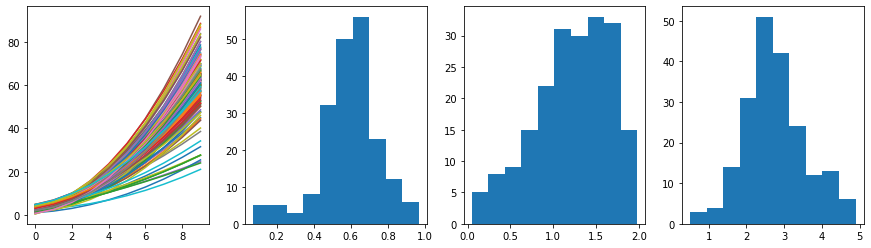

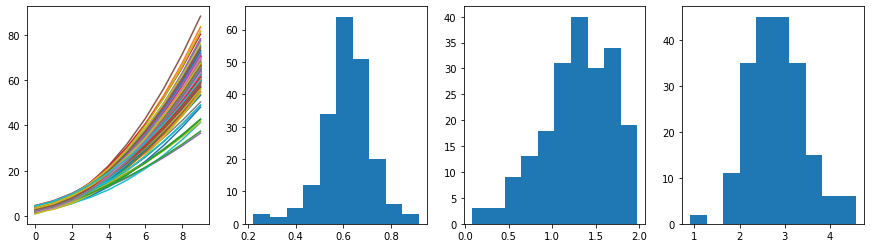

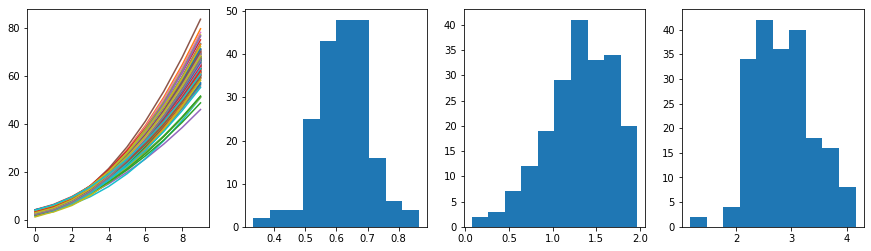

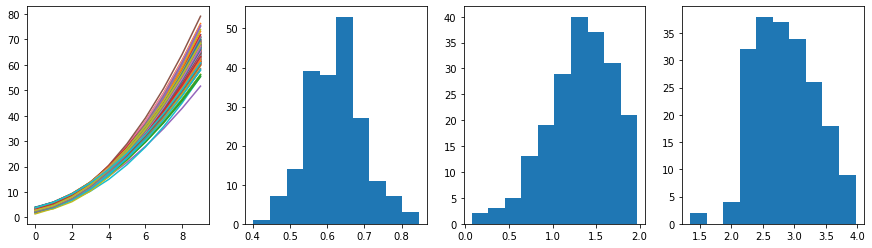

In [5]:
import numpy as np
from matplotlib import pyplot as plt
from ert.analysis import ies


def iterative_smoother():
    A_current = np.copy(A)
    iterations = 4
    obs_mask = [True for _ in observation_values]
    ens_mask = [True for _ in range(realizations)]
    module_data = ies.ModuleData(realizations)
    module_config = ies.Config(True)

    for i in range(iterations):

        plot_result(A_current, response_x_axis, uniform, priors, True)
        responses_before = forward_model(A_current, priors, response_x_axis)
        S = responses_before[observation_x_axis]
        noise = np.random.rand(*S.shape)
        E = ies.make_E(observation_errors, noise)
        R = np.identity(len(observation_errors))
        D = ies.make_D(observation_values, E, S)
        D = (D.T / observation_errors).T
        E = (E.T / observation_errors).T
        S = (S.T / observation_errors).T

        ies.init_update(module_data, ens_mask, obs_mask)
        iteration_nr = module_data.iteration_nr
        step_length = module_config.get_steplength(iteration_nr)
        ies.update_A(
            module_data,
            A_current,
            S,
            R,
            E,
            D,
            step_length=step_length,
        )
        module_data.iteration_nr += 1

    plot_result(A_current, response_x_axis, uniform, priors, True)


iterative_smoother()